# Climate Change Belief Analysis 2022


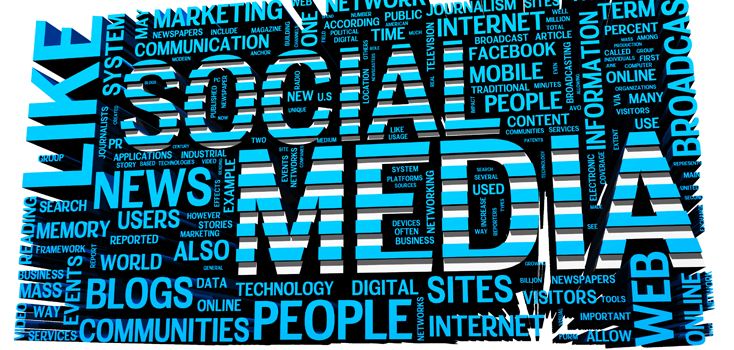

### About the problem

Many companies are built around lessening one’s environmental impact or carbon footprint. They     offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.
                
### The Objective

Create a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.


Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.


                
   
                
                
            


<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

<a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>



In [1]:
# Libraries for data loading, data manipulation and data visulisation
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer

# Libraries for model building
import tensorflow
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# Libraries for data preprocessing and model performance
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score,classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV





[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
samplesubmission = pd.read_csv('sample_submission.csv')

print(train.shape)
print(test.shape)
print(samplesubmission.shape)

(15819, 3)
(10546, 2)
(10546, 2)


In [3]:
train.head(3)

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562


In [4]:
test.head(3)

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985


<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [5]:
train.isnull().any()
test.isnull().any()

message    False
tweetid    False
dtype: bool

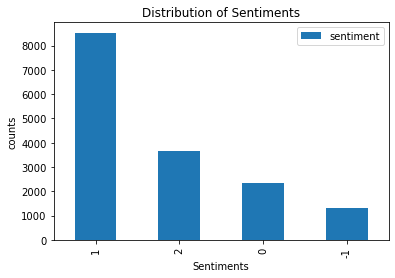

In [6]:
#Lets take a look at our sentiments

pd.value_counts(train['sentiment']).plot.bar()
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiments')
plt.ylabel('counts')
plt.legend()
plt.show()

In [7]:
train.groupby('sentiment').describe()

tweetid                                                             \
            count           mean            std     min        25%       50%   
sentiment                                                                      
-1         1296.0  499169.447531  289509.003781  1422.0  243479.25  494572.0   
 0         2353.0  496550.249894  286519.834520   229.0  250733.00  483496.0   
 1         8530.0  507418.550762  289537.581404     6.0  257622.75  511867.5   
 2         3640.0  492613.500275  289163.550697    86.0  246628.25  490980.0   

                                
                 75%       max  
sentiment                       
-1         759714.75  999537.0  
 0         734897.00  999888.0  
 1         761983.50  999698.0  
 2         738188.50  999236.0

In [8]:
# adding a column to represent the length of the tweet

train['len'] = train['message'].str.len()
test['len'] = test['message'].str.len()

train.head(10)

,sentiment,message,tweetid,len
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,140
1,1,It's not like we lack evidence of anthropogeni...,126103,62
2,2,RT @RawStory: Researchers say we have three ye...,698562,140
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,99
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,122
5,1,Worth a read whether you do or don't believe i...,425577,110
6,1,RT @thenation: Mike Pence doesn’t believe in g...,294933,119
7,1,RT @makeandmendlife: Six big things we can ALL...,992717,152
8,1,@AceofSpadesHQ My 8yo nephew is inconsolable. ...,664510,139
9,1,RT @paigetweedy: no offense… but like… how do ...,260471,88


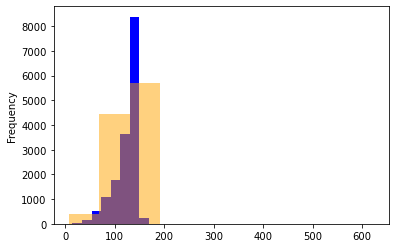

In [9]:
# checking the distribution of tweets in the data

length_train = train['message'].str.len().plot.hist(color = 'blue', figsize = (6, 4))
length_test = test['message'].str.len().plot.hist(color = 'orange', figsize = (6, 4), alpha=0.5)

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

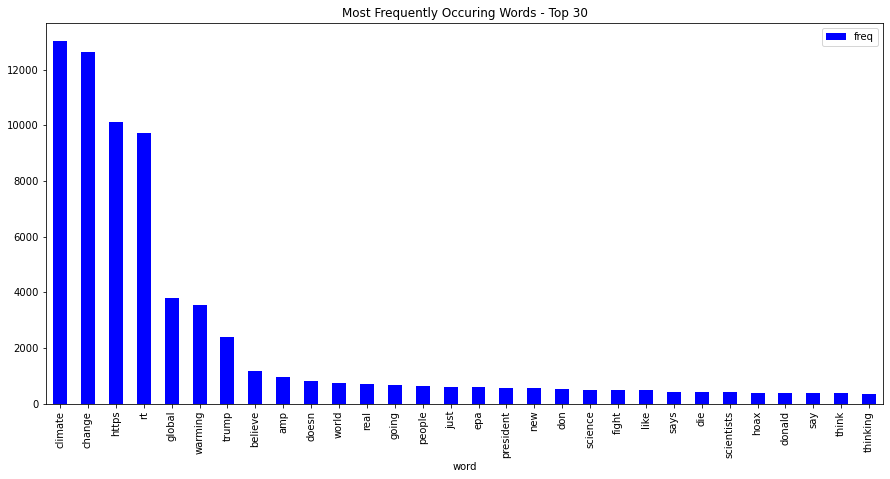

In [10]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train.message)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

Text(0.5, 1.0, 'WordCloud - Vocabulary from General Tweets')

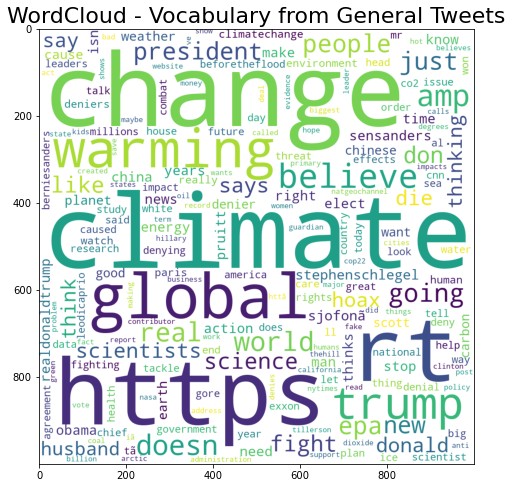

In [11]:
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from General Tweets", fontsize = 22)

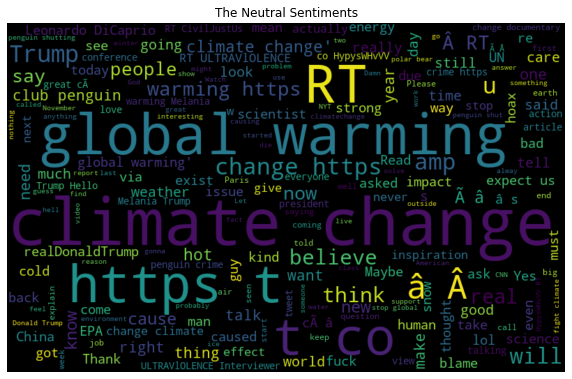

In [12]:
neutral_words =' '.join([text for text in train['message'][train['sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(neutral_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Sentiments')
plt.show()

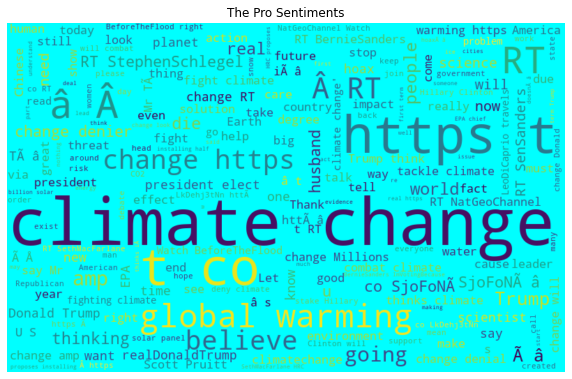

In [13]:
pro_words =' '.join([text for text in train['message'][train['sentiment'] == 1]])

wordcloud = WordCloud(background_color = 'cyan', width=800, height=500, random_state = 0, max_font_size = 110).generate(pro_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Pro Sentiments')
plt.show()

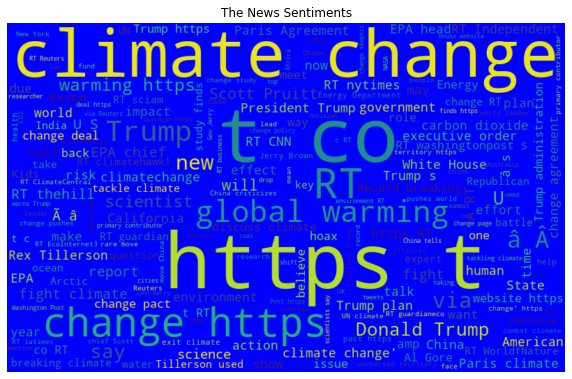

In [14]:
news_words =' '.join([text for text in train['message'][train['sentiment'] == 2]])

wordcloud = WordCloud(background_color = 'blue', width=800, height=500, random_state = 0, max_font_size = 110).generate(news_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The News Sentiments')
plt.show()

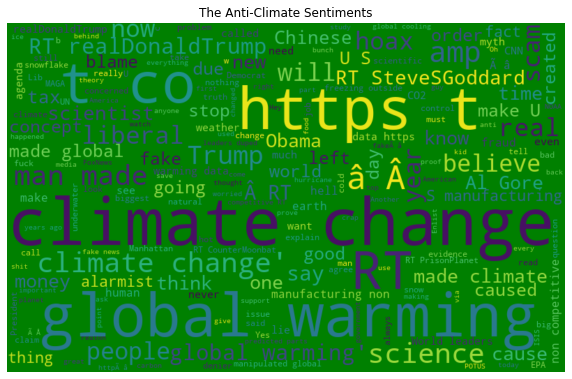

In [16]:
anti_words =' '.join([text for text in train['message'][train['sentiment'] == -1]])

wordcloud = WordCloud(background_color = 'green', width=800, height=500, random_state = 0, max_font_size = 110).generate(anti_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Anti-Climate Sentiments')
plt.show()

In [17]:
# collecting the hashtags

def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [18]:
# extracting hashtags from News tweets
HT_News = hashtag_extract(train['message'][train['sentiment'] == 2])

# extracting hashtags from Pro tweets
HT_Pro = hashtag_extract(train['message'][train['sentiment'] == 1])

# extracting hashtags from neutral tweets
HT_Neutral = hashtag_extract(train['message'][train['sentiment'] == 0])

# extracting hashtags from anti-climate tweets
HT_Anti = hashtag_extract(train['message'][train['sentiment'] == -1])

# unnesting list
HT_News = sum(HT_News,[])
HT_Pro = sum(HT_Pro,[])
HT_Neutral = sum(HT_Neutral,[])
HT_Anti = sum(HT_Anti,[])

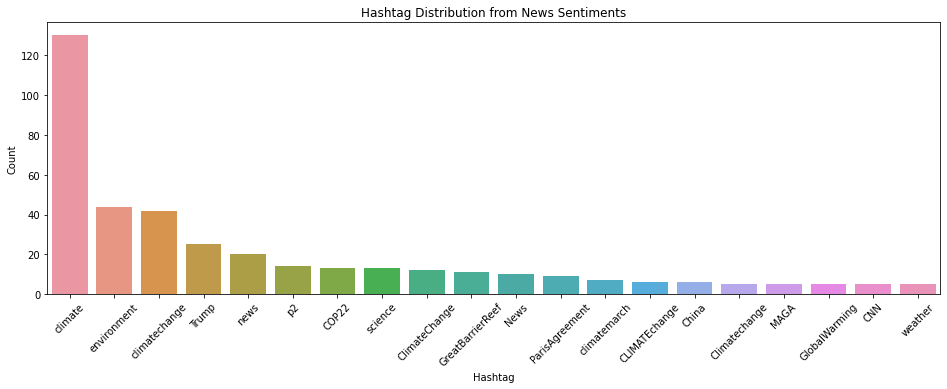

In [19]:
a = nltk.FreqDist(HT_News)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title('Hashtag Distribution from News Sentiments')
plt.xticks(rotation=45)
plt.show()

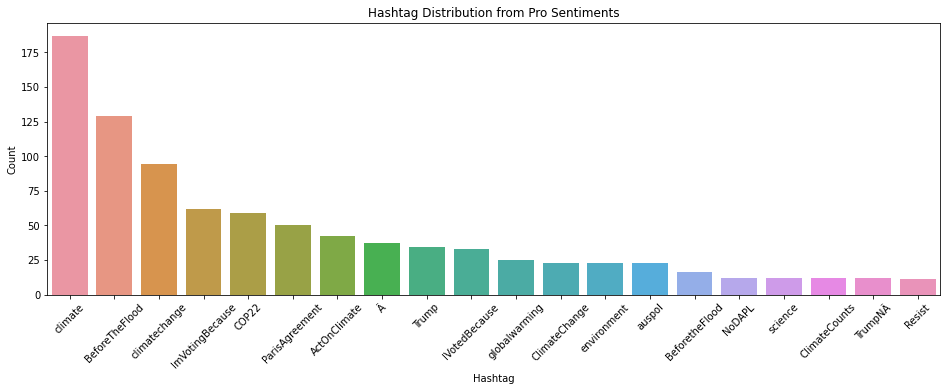

In [20]:
a = nltk.FreqDist(HT_Pro)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title('Hashtag Distribution from Pro Sentiments')
plt.xticks(rotation=45)
plt.show()

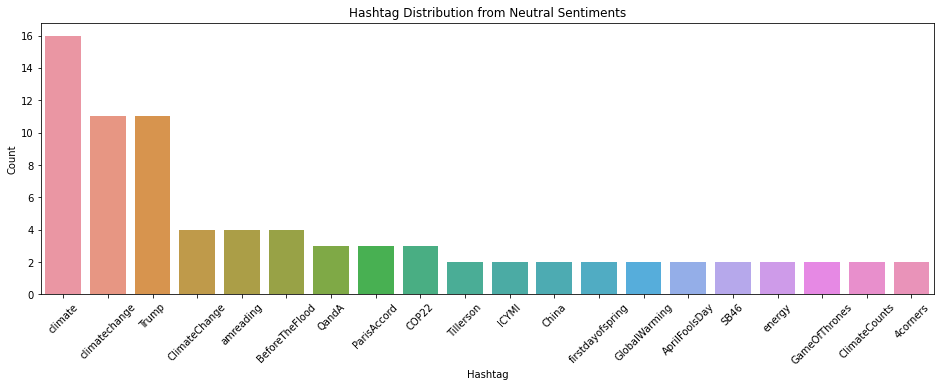

In [21]:
a = nltk.FreqDist(HT_Neutral)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title('Hashtag Distribution from Neutral Sentiments')
plt.xticks(rotation=45)
plt.show()

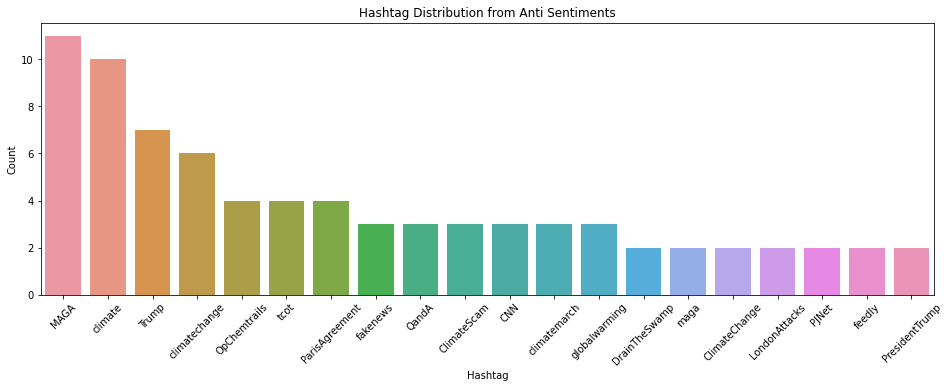

In [54]:
a = nltk.FreqDist(HT_Anti)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title('Hashtag Distribution from Anti Sentiments')
plt.xticks(rotation=45)
plt.show()

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In [31]:
# removing unwanted patterns from the data

def data_cleaning(data):
    cleaned_data = []
    fillerWord = ("so","yeah","okay","um","uh","mmm","ahan","uh","huh","ahm","oh","sooo","uh","huh","yeh","yah","hmm","bye")
    fillerword_reg= "bye[.,]|so[.,]|yeah[.,]|okay[.,]|um[.,]|uh[.,]|mmm[.,]|ahan[.,]|uh[.,]|huh[.,]|ahm[.,]|oh[.,]|sooo[.,]|uh[.,]|huh[.,]|yeh[.,]|yah[.,]|hmm[.,]"
    STOPWORDS = set(stopwords.words('english'))
    remove=["doesn't","not","nor","neither","isn't","hadn't","mightn't","needn't","wasn't","haven't"]
    for i in remove:
        STOPWORDS.discard(i)
    
    STOPWORDS.add(fillerWord)  
    for i in range(len(data)):
        tweet = re.sub("#", "", data[i])#extracting hashtags
        tweet = re.sub(r'^https?:\/\/.*[\r\n]*', '',tweet, flags=re.MULTILINE)#extracting links
        html=re.compile(r'<.*?>')#extracting html tags
        tweet =html.sub(r"", tweet)
        #extracting symbols and characters
        tweet=re.sub(r'@\w+',"",tweet)
        tweet=re.sub(r'#\w+',"",tweet) 
        tweet=re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet) 
        punctuation = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""
        tweet.rstrip(string.punctuation)
        tweet=re.sub('[^A-Za-z\s]+',"", tweet)
        # Remove words with 2 or fewer letters
        tweet = re.sub(r'\b\w{1,2,3}\b', '', tweet)
        tweet = tweet.lower()
        tweet = tweet.split()
        #Lemmatization to normalise text
        lemmatizer = WordNetLemmatizer()
        tweet = [lemmatizer.lemmatize(word) for word in tweet if not word in STOPWORDS]
        tweet = ' '.join(tweet)
        filler=re.compile(fillerword_reg)
        tweet=filler.sub("",tweet)
        cleaned_data.append(tweet)
    return cleaned_data

In [32]:
####Preprocessing and cleaning train data
text_data=train['message'].tolist()
process_text=data_cleaning(text_data)

cleaned_tweet =pd.DataFrame(process_text)
train['CleanedTweet']=cleaned_tweet
#cleaned_tweet.head()


train.head()

,sentiment,message,tweetid,len,CleanedTweet
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,140,polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,62,not like lack evidence anthropogenic global wa...
2,2,RT @RawStory: Researchers say we have three ye...,698562,140,rt researcher say three year act climate chang...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,99,todayinmaker wired pivotal year war climate ch...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,122,rt racist sexist climate change denying bigot ...


In [34]:
####Preprocessing and cleaning test data
test['len']= test['message'].apply(lambda x:len(x))
texto_data=test['message'].tolist()
process_text=data_cleaning(texto_data)

cleaned_tweet =pd.DataFrame(process_text)
test['CleanedTweet']=cleaned_tweet
#cleaned_tweet.head()
test.head()

,message,tweetid,len,CleanedTweet
0,Europe will now be looking to China to make su...,169760,121,europe looking china make sure not alone fight...
1,Combine this with the polling of staffers re c...,35326,132,combine polling staffer climate change woman r...
2,"The scary, unimpeachable evidence that climate...",224985,139,scary unimpeachable evidence climate change al...
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,136,putin got jill trump doesnt believe climate ch...
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,79,rt female orgasm cause global warming sarcasti...


In [35]:
#Adding length of cleaned tweet to dataset
train['NewLen']= train['CleanedTweet'].apply(lambda x:len(x))
test['NewLen']= test['CleanedTweet'].apply(lambda x:len(x))
train.head()

,sentiment,message,tweetid,len,CleanedTweet,NewLen
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,140,polyscimajor epa chief doesnt think carbon dio...,85
1,1,It's not like we lack evidence of anthropogeni...,126103,62,not like lack evidence anthropogenic global wa...,51
2,2,RT @RawStory: Researchers say we have three ye...,698562,140,rt researcher say three year act climate chang...,52
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,99,todayinmaker wired pivotal year war climate ch...,50
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,122,rt racist sexist climate change denying bigot ...,72


<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

In [39]:
# creating bag of words

vectorizer = CountVectorizer(max_features= 3000, min_df = 3, max_df = 0.6)
# fit the model for training data
X = vectorizer.fit_transform(train.CleanedTweet)
y = train.iloc[:, 0]

print(X.shape)
print(y.shape)

(15819, 3000)
(15819,)


In [40]:
# creating bag of words for test data
x_test = vectorizer.fit_transform(test.CleanedTweet)

print(x_test.shape)

(10546, 3000)


In [42]:
from sklearn.feature_extraction.text import TfidfTransformer

In [43]:
transformer = TfidfTransformer()
X_data = transformer.fit_transform(X).toarray()
x_test = transformer.fit_transform(x_test).toarray()
print(X_data.shape)
print(x_test.shape)
#X_train_data[0]

(15819, 3000)
(10546, 3000)


In [44]:
#Split the X data into train and valid 

x_train, x_valid, y_train, y_valid = train_test_split(X_data, y, test_size = 0.30, random_state = 15)

#### Model 1: Random Forest

In [45]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

rf_pred = rf.predict(x_valid)

print("Training Accuracy :", rf.score(x_train, y_train))
print("Validation Accuracy :", rf.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, rf_pred, average='weighted'))

# confusion matrix
cm = confusion_matrix(y_valid, rf_pred)
print(cm)

Training Accuracy : 0.9944007947259099
Validation Accuracy : 0.7071217867678045
F1 score : 0.6888933645068748
[[ 100   43  207   32]
 [  13  267  336   69]
 [  13  104 2231  246]
 [   5   37  285  758]]


#### Model 2: Gradient Boasting Classifier

In [53]:
gboost = GradientBoostingClassifier()
gboost.fit(x_train, y_train)

gb_predict = gboost.predict(x_valid)

print("Training Accuracy :", gboost.score(x_train, y_train))
print("Validation Accuracy :", gboost.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, gb_pred, average='weighted'))

# confusion matrix
cm = confusion_matrix(y_valid, gb_pred)
print(cm)
print("\n\nClassification Report:\n\n", classification_report(y_valid, y_pred))

KeyboardInterrupt: 

### Model 3: Naive Bayes Multinomial Classifier

In [49]:
m_nb = MultinomialNB()
m_nb.fit(x_train,y_train)

nb_predict = m_nb.predict(x_valid)

print("Training Accuracy :", m_nb.score(x_train, y_train))
print("Validation Accuracy :", m_nb.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, nb_predict, average='weighted'))

# confusion matrix
cm = confusion_matrix(y_valid, nb_predict)
print(cm)
print("\n\nClassification Report:\n\n", classification_report(y_valid, nb_predict))

Training Accuracy : 0.7269935880068635
Validation Accuracy : 0.6833122629582806
F1 score : 0.6339175093993473
[[  55   15  295   17]
 [   1  105  535   44]
 [   1   26 2424  143]
 [   2    9  415  659]]


Classification Report:

               precision    recall  f1-score   support

          -1       0.93      0.14      0.25       382
           0       0.68      0.15      0.25       685
           1       0.66      0.93      0.77      2594
           2       0.76      0.61      0.68      1085

    accuracy                           0.68      4746
   macro avg       0.76      0.46      0.49      4746
weighted avg       0.71      0.68      0.63      4746



### Model 4: Logistic Regression

In [51]:
lgr = LogisticRegression()
lgr.fit(x_train, y_train)

lgr_pred = lgr.predict(x_valid)

print("Training Accuracy :", lgr.score(x_train, y_train))
print("Validation Accuracy :", lgr.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, lgr_pred, average='weighted'))

# confusion matrix
cm = confusion_matrix(y_valid, lgr_pred)
print(cm)
print("\n\nClassification Report:\n\n", classification_report(y_valid, lgr_pred))

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Training Accuracy : 0.7964417953580782
Validation Accuracy : 0.7088074167720185
f1 score : 0.6885446387887607
[[ 112   38  213   19]
 [  11  239  369   66]
 [  19   98 2280  197]
 [   3   22  327  733]]


Classification Report:

               precision    recall  f1-score   support

          -1       0.77      0.29      0.43       382
           0       0.60      0.35      0.44       685
           1       0.71      0.88      0.79      2594
           2       0.72      0.68      0.70      1085

    accuracy                           0.71      4746
   macro avg       0.70      0.55      0.59      4746
weighted avg       0.70      0.71      0.69      4746



### Model 5: Support Vector Classifier

In [52]:
svc = SVC()
svc.fit(x_train, y_train)

svc_pred = svc.predict(x_valid)

print("Training Accuracy :", svc.score(x_train, y_train))
print("Validation Accuracy :", svc.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, svc_pred, average='weighted'))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)
print("\n\nClassification Report:\n\n", classification_report(y_valid, svc_pred))

KeyboardInterrupt: 

### Model 6: Neural Network

### Model 7: XGBoost

In [55]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(x_train, y_train)

xgb_pred = xgb.predict(x_valid)

print("Training Accuracy :", xgb.score(x_train, y_train))
print("Validation Accuracy :", xgb.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, xgb_pred, average='weighted'))

# confusion matrix
cm = confusion_matrix(y_valid, xgb_pred)
print(cm)
print("\n\nClassification Report:\n\n", classification_report(y_valid, xgb_pred))

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:42:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy : 0.7866883410096631
Validation Accuracy : 0.690897597977244
f1 score : 0.6648558715544693
[[ 112   34  215   21]
 [  16  206  416   47]
 [  13   70 2338  173]
 [   7   20  435  623]]


Classification Report:

               precision    recall  f1-score   support

          -1       0.76      0.29      0.42       382
           0       0.62      0.30      0.41       685
           1       0.69      0.90      0.78      2594
           2       0.72      0.57      0.64      1085

    accuracy                           0.69      4746
   macro avg       0.70      0.52      0.56      4746
weighted avg       0.69      0.69      0.66      4746



<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [56]:
rf1_pred = rf.predict(x_test)

In [57]:
lg1_pred = lgr.predict(x_test)
m_nb_pred = m_nb.predict(x_test)
gb = xgb.predict(x_test)

In [63]:
xgb2 = XGBClassifier()
xgb2.fit(X, y)

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:55:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [64]:
xgb3 = xgb2.predict(x_test)

In [58]:
# # Create a submission file xgb
sub_file1 = samplesubmission.copy()

sub_file1.sentiment = rf1_pred
sub_file1.to_csv("rf_test.csv", index = False)

In [59]:
sub_file2 = samplesubmission.copy()

sub_file2.sentiment = lg1_pred
sub_file2.to_csv("lg_test.csv", index = False)

In [66]:
sub_file3 = samplesubmission.copy()

sub_file3.sentiment = xgb3
sub_file3.to_csv("gb2_test.csv", index = False)

In [62]:
sub_file4 = samplesubmission.copy()

sub_file4.sentiment = m_nb_pred
sub_file4.to_csv("nb_test.csv", index = False)

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>